<a href="https://colab.research.google.com/github/cmb170230/NLP-Portfolio/blob/main/Text%20Classification/Sentiment%20Analysis%20with%20NB%2C%20LogRegression%2C%20and%20NN%20Classifiers" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
sentfile = tf.keras.utils.get_file('sld.zip', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip')
!unzip /root/.keras/datasets/sld.zip

Archive:  /root/.keras/datasets/sld.zip
replace sentiment labelled sentences/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sentiment labelled sentences/.DS_Store  
replace __MACOSX/sentiment labelled sentences/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/sentiment labelled sentences/._.DS_Store  
replace sentiment labelled sentences/amazon_cells_labelled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  
replace sentiment labelled sentences/imdb_labelled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sentiment labelled sentences/imdb_labelled.txt  
replace __MACOSX/sentiment labelled sentences/._imdb_labelled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/sentiment labelled sentences/._imdb_labelled.txt  
replace sentiment labelled sentences/readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sentiment labelled sentences/readme.txt 

In [ ]:
import os
os.mkdir('__MACOSX/Data')
os.mkdir('__MACOSX/Data/Negative')
os.mkdir('__MACOSX/Data/Positive')

In [6]:
restructure = open('/content/sentiment labelled sentences/amazon_cells_labelled.txt')

filelist = restructure.readlines()
restructure.close()
i = 0
for line in filelist:
  if(line[-2] == '0'):
    fileformat = '__MACOSX/Data/Negative/zero{}.txt'
    filename = fileformat.format(i)
    zerofile = open(filename, 'w')
    zerofile.write(line[0:-2])
    zerofile.close()
  else:
    fileformat = '__MACOSX/Data/Positive/one{}.txt'
    filename = fileformat.format(i)
    onefile = open(filename, 'w')
    onefile.write(line[0:-2])
    onefile.close()
  i += 1

In [7]:
train = tf.keras.utils.text_dataset_from_directory("__MACOSX/Data", label_mode = 'binary', 
                                                   batch_size = 50, seed = 84, validation_split = 0.2, subset = 'training')
test = tf.keras.utils.text_dataset_from_directory("__MACOSX/Data", label_mode = 'binary', 
                                                  batch_size = 50, seed = 84, validation_split = 0.2, subset = 'validation')

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [8]:
VOCAB_SIZE = 1670
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [9]:
# Define a function to extract the data from a tensorflow dataset so that we can work with Pandas Dataframes/Series objects
# when using Sklearn Naive Bayes
def get_tf_data(data):
  dat = []

  for feature_batch, label_batch in data.take(-1):
    for features, label in zip(feature_batch.numpy(), label_batch.numpy()):
      dat.append((features, label[0]))

  return dat

train_df = pd.DataFrame(get_tf_data(train), columns = ['Text', 'Sentiment'])
test_df = pd.DataFrame(get_tf_data(test), columns = ['Text', 'Sentiment'])

#Exploration of the Data

This dataset consists of 3000 reviews, 1000 from each of three sites: imdb.com, amazon.com, and yelp.com. The target task for these data is sentiment analysis, with 500 files containing positively labeled reviews and 500 containing negatively labeled reviews for each site.

In [47]:
catplotdata = pd.concat([train_df, test_df])
catplotdata.head()


,Text,Sentiment
0,b'AFTER ARGUING WITH VERIZON REGARDING THE DRO...,0.0
1,"b""Unfortunately it's easy to accidentally acti...",0.0
2,b'The reception is excellent!\t',1.0
3,b'Arrived quickly and much less expensive than...,1.0
4,"b'Great it was new packaged nice works good, n...",1.0


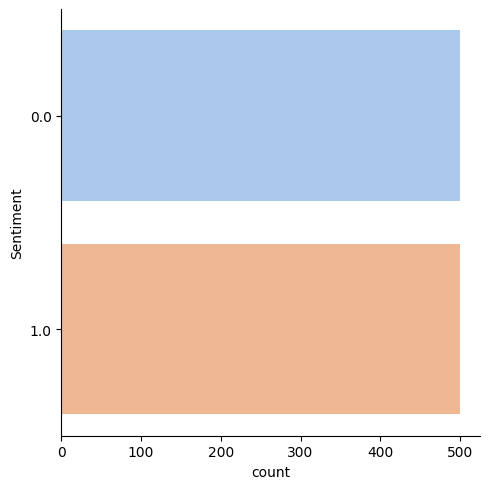

In [48]:
sns.catplot(data = catplotdata, x=None, y="Sentiment", kind="count", palette="pastel")

#Naive Bayes

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

X_train = train_df['Text']
y_train = train_df['Sentiment']

X_test = test_df['Text']
y_test = test_df['Sentiment']

## Pipeline and GridSearchCV for Optimal Naive Bayes Variant and Hyperparameters

In [49]:
from sklearn.utils.metaestimators import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a generic class for usage with Sklearn estimators so that we can 
# test multiple models (MultinomialNB and BernoulliNB) using the same pipeline
class naive_bayes_mod(BaseEstimator):
  def __init__(self, estimator = MultinomialNB()):
    self.estimator = estimator

  def fit(self, X, y = None, **kwargs):
    self.estimator.fit(X, y)
    return self

  def predict(self, X, y = None):
    return self.estimator.predict(X)

  def score(self, X, y):
    return self.estimator.score(X, y)

pipe = Pipeline(steps = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('nb', naive_bayes_mod())
])

params = [{ 
    # First dictionary is for multinomial naive bayes
    'count_vectorizer__stop_words': ['english', None],           # English stop words set has many known problems, so try the vectorization 
                                                                 # without using stop words at all
           
    'tfidf_transformer': [TfidfTransformer(), 'passthrough'],    # Whether to use count vectorized (skipping the TfidfTransformer step) 
                                                                 # or tfidf vectorized
    'nb__estimator': [MultinomialNB()],
    'nb__estimator__alpha': [0.001, 0.25, 0.5, 0.75, 1],
    'nb__estimator__class_prior': [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
}, {
    # Second dictionary is for bernoulli naive bayes
    'count_vectorizer__stop_words': ['english', None],   
    'count_vectorizer__binary' : [True],                         # Only use binary word occurrence for bernoulli
    'tfidf_transformer': ['passthrough'],                        # Skip the TfidfTransformer step
    'nb__estimator': [BernoulliNB()],
    'nb__estimator__alpha': [0.001, 0.25, 0.5, 0.75, 1],
    'nb__estimator__class_prior': [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
}]

grid_nb = GridSearchCV(pipe, params, cv = 10, scoring = 'accuracy').fit(X_train, y_train)

In [12]:
grid_nb.best_params_

{'count_vectorizer__stop_words': None,
 'nb__estimator': MultinomialNB(alpha=0.75, class_prior=(0.5, 0.5)),
 'nb__estimator__alpha': 0.75,
 'nb__estimator__class_prior': (0.5, 0.5),
 'tfidf_transformer': TfidfTransformer()}

In [13]:
# best_estimator_ returns the entire pipeline, so we can use the predict method directly on un-vectorized test data
best_nb = grid_nb.best_estimator_

In [32]:
#recover optimal parameters from the model
best_nb.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('nb',
                 naive_bayes_mod(estimator=MultinomialNB(alpha=0.75,
                                                         class_prior=(0.5,
                                                                      0.5))))])>

## Prediction on Test Data

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85        97
    positive       0.88      0.83      0.86       103

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200



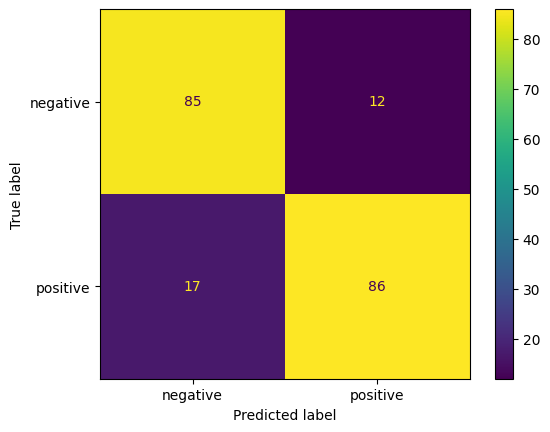

In [14]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

mappings = {0 : 'negative', 1 : 'positive'}

# Predict on the test data and print evaluation metrics
preds = best_nb.predict(X_test)
print(classification_report(y_test, preds, target_names = mappings.values()))
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = mappings.values())

In [15]:
misclassification_count = 0
correct_disp = 0
i = 0
print("INCORRECT PREDICTIONS:")
while misclassification_count < 10:
  if (preds[i] != y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    misclassification_count += 1
  i += 1

print("CORRECT PREDICTIONS:")
i = 0
while correct_disp < 10:
  if (preds[i] == y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    correct_disp += 1

  i += 1

INCORRECT PREDICTIONS:
	"Phone now holds charge like it did when it was new."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"The mic there is a joke, and the volume is quite low."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Small, sleek, impressive looking, practical setup with ample storage in place."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"I gave it 5 stars because of the sound quality."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"You'll love how thin it is."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"The volume for the ringer is REAL good (you have choices how loud)."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"I have bought this Nokia cell phone a few weeks ago and it was a nightmare."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"It defeats the purpose of a bluetooth headset."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"The phone gets EXTR

#Logistic Regressor GridSearchCV for Optimal Hyperparameters



In [ ]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('linreg', LogisticRegression())
])

params = [{ 
    'count_vectorizer__stop_words': ['english', None],           # English stop words set has many known problems, so try the vectorization 
                                                                 # without using stop words at all
           
    'tfidf_transformer': [TfidfTransformer(), 'passthrough'],    # Whether to use count vectorized (skipping the TfidfTransformer step) 
                                                                 # or tfidf vectorized
    'linreg__penalty': ['l1', 'l2', 'elasticnet', None],                 
    'linreg__tol' : [1e-3, 1e-4, 1e-5, 1e-6],
    'linreg__C' : [0.1, 1, 10, 100, 1000],
    'linreg__class_weight' : ['balanced', None],
    'linreg__random_state' : [12]
}]

grid_logr = GridSearchCV(pipe, params, cv = 10, scoring = 'accuracy').fit(X_train, y_train)

In [30]:
# best_estimator_ returns the entire pipeline, so we can use the predict method directly on un-vectorized test data
best_linreg = grid_logr.best_estimator_

In [31]:
#recover optimal parameters from the model
best_linreg.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', 'passthrough'),
                ('nn',
                 MLPClassifier(batch_size=50, hidden_layer_sizes=(100, 50),
                               learning_rate='invscaling', max_iter=300,
                               random_state=12))])>

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86        97
    positive       0.86      0.86      0.86       103

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



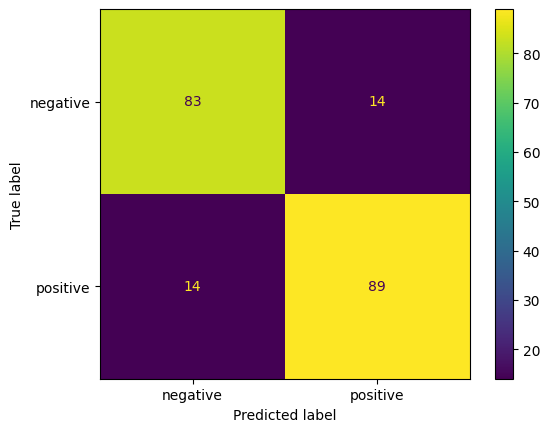

In [18]:
# Predict on the test data and print evaluation metrics
preds = best_linreg.predict(X_test)
print(classification_report(y_test, preds, target_names = mappings.values()))
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = mappings.values())

In [19]:
misclassification_count = 0
correct_disp = 0
i = 0
print("INCORRECT PREDICTIONS:")
while misclassification_count < 10:
  if (preds[i] != y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    misclassification_count += 1
  i += 1

print("CORRECT PREDICTIONS:")
i = 0
while correct_disp < 10:
  if (preds[i] == y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    correct_disp += 1

  i += 1

INCORRECT PREDICTIONS:
	"The mic there is a joke, and the volume is quite low."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Small, sleek, impressive looking, practical setup with ample storage in place."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"Disappointing accessory from a good manufacturer."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!"
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Beautiful styling though."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"Timely shipment and quality product."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"I have bought this Nokia cell phone a few weeks ago and it was a nightmare."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"It defeats the purpose of a bluetooth headset."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Buttons are too small.

#Neural Network GridSearchCV for Optimal Hyperparameters

In [ ]:
from sklearn.neural_network import MLPClassifier

#takes 2 hours 36 minutes to complete, do not run

pipe = Pipeline(steps = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('nn', MLPClassifier())
])

params = [{ 
    'count_vectorizer__stop_words': ['english', None],           # English stop words set has many known problems, so try the vectorization 
                                                                 # without using stop words at all
           
    'tfidf_transformer': [TfidfTransformer(), 'passthrough'],    # Whether to use count vectorized (skipping the TfidfTransformer step) 
                                                                 # or tfidf vectorized
    'nn__hidden_layer_sizes' : [(50,), (50,25), (100,), (100, 50)],
    'nn__solver' : ['lbfgs', 'sgd', 'adam'],
    'nn__alpha' : [0.001, 0.0001],
    'nn__batch_size' : [50],
    'nn__learning_rate' : ['invscaling', 'adaptive'],
    'nn__random_state' : [12],
    'nn__max_iter' : [300]

}]

grid = GridSearchCV(pipe, params, cv = 10, scoring = 'accuracy').fit(X_train, y_train)

In [28]:
# best_estimator_ returns the entire pipeline, so we can use the predict method directly on un-vectorized test data
best_nn = grid.best_estimator_

In [29]:
#recover optimal parameters from the model
best_nn.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', 'passthrough'),
                ('nn',
                 MLPClassifier(batch_size=50, hidden_layer_sizes=(100, 50),
                               learning_rate='invscaling', max_iter=300,
                               random_state=12))])>

In [ ]:
##Saving best hyperparameters separately due to egregious runtime
#<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer()),
#                ('tfidf_transformer', 'passthrough'),
#                ('nn',
#                 MLPClassifier(batch_size=50, hidden_layer_sizes=(100, 50),
#                               learning_rate='invscaling', max_iter=300,
#                               random_state=12))])>

              precision    recall  f1-score   support

    negative       0.84      0.88      0.86        97
    positive       0.88      0.84      0.86       103

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



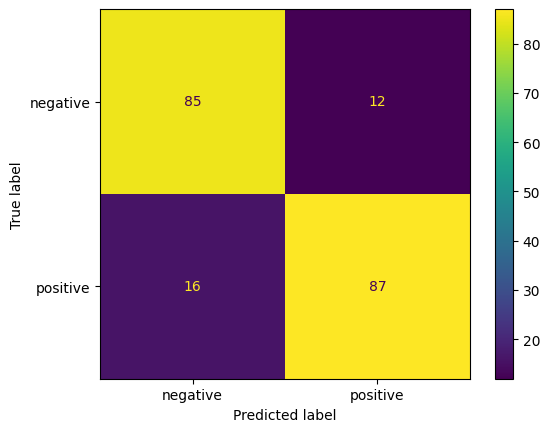

In [24]:
# Predict on the test data and print evaluation metrics
preds = best_linreg.predict(X_test)     
print(classification_report(y_test, preds, target_names = mappings.values()))
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = mappings.values())

In [25]:
misclassification_count = 0
correct_disp = 0
i = 0
print("INCORRECT PREDICTIONS:")
while misclassification_count < 10:
  if (preds[i] != y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    misclassification_count += 1
  i += 1

print("CORRECT PREDICTIONS:")
i = 0
while correct_disp < 10:
  if (preds[i] == y_test[i]):
    print('\t"' + str(X_test[i])[2:-3] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    correct_disp += 1

  i += 1

INCORRECT PREDICTIONS:
	"But despite these few flaws, this case is of exceptional quality and well worth the additional costs of owning an official OEM product."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"The mic there is a joke, and the volume is quite low."
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Small, sleek, impressive looking, practical setup with ample storage in place."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!"
	Actual Sentiment: negative		Predicted Sentiment: positive

	"Timely shipment and quality product."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"I gave it 5 stars because of the sound quality."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"You'll love how thin it is."
	Actual Sentiment: positive		Predicted Sentiment: negative

	"The volume for the ringer is REAL good (you have choices how loud)."
	Ac

Overall, for this dataset model performance is best explored from a compute/training runtime perspective rather than a task performance perspective, as all three metrics achieved precision, recall, f1, and accuracy values within the margin of error of each other. From this perspecive, the Naive Bayes classifier is vastly superior, combing through a far larger parameter grid in a fraction of the time relative to logistic regression and especially the neural network approach. 